In this notebook, we show the performance of our model by comparing a strategy of buying and selling S&P 500 stocks based on the predictions of our model. This is a good method of evaluation as it allows us to get a feel of how our model would perform in a real life scenario.

The first step is to load the model we generated from the main file and set it to evaluation mode.

In [3]:
import import_ipynb
import model_nt
import torch
import numpy as np

model = model_nt.NewsTechLSTM()
model.load_state_dict(torch.load("Models/best_news_tech_model.pt"))
model.eval()

NewsTechLSTM(
  (conv1): Conv1d(100, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (news_lstm): LSTM(64, 128, batch_first=True)
  (tech_lstm): LSTM(7, 64, batch_first=True)
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

Then we load the financial data for the period we want to test on, we use the extract_embedding_data function to generate a csv over the same time frame. We pass them through the layer functions to generate the technical and embedding layers and merge them accordingly for later use.

In [4]:
import layers_nt
import yfinance as yf
import pandas as pd

technical_indicators = layers_nt.calculate_technical_indicator(start_date='2019-05-31', end_date='2020-06-01')
trading_days = pd.to_datetime(technical_indicators['Date']).dt.tz_localize(None).dt.date
daily_news_trading_days = layers_nt.calculate_embedding_layer('test2020.csv',trading_days)

merged = technical_indicators
merged['sentence_vector'] = daily_news_trading_days['sentence_vector']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


For testing we "invested" $1000 of capital into a strategy of buy and hold and one based on the predictions of our model. If the model predicts a positive movement, the strategy adjusts the capital based on the percentage change in the closing price; otherwise, it holds its capital in cash and no affects are added.

After iterating through the dataset, the final capital of both strategies is printed for comparison, showing how the model's decisions impacted the simulated trading outcome relative to a passive strategy.

In [5]:
initial_capital = 1000
buy_hold_capital = [initial_capital]
model_capital = [initial_capital]
capital = initial_capital

lookback = 3

for i in range(lookback, len(merged) - 1):
    news_seq = np.stack(merged['sentence_vector'].iloc[i-lookback:i].values)
    tech_seq = merged[['Stochastic_%K', 'Williams_%R', 'Stochastic_%D','AD_Oscillator', 'Momentum', 'Disparity', 'ROC']].iloc[i-lookback:i].values

    news_tensor = torch.tensor(news_seq[np.newaxis, ...], dtype=torch.float32)
    tech_tensor = torch.tensor(tech_seq[np.newaxis, ...], dtype=torch.float32)

    with torch.no_grad():
        out = model(news_tensor, tech_tensor)
        pred = torch.argmax(out, dim=1).item()

    today_close = merged['Close'].iloc[i].values[0]
    next_close = merged['Close'].iloc[i + 1].values[0]
    pct_change = (next_close - today_close) / today_close

    if pred == 1:
        capital = capital * (1 + pct_change)
    model_capital.append(capital)

    buy_hold_capital.append(buy_hold_capital[-1] * (1 + pct_change))

final_model_cap = model_capital[-1]
final_bh_cap = buy_hold_capital[-1]

print(f"Final Capital (Model Strategy): ${final_model_cap:.2f}")
print(f"Final Capital (Buy & Hold): ${final_bh_cap:.2f}")

Final Capital (Model Strategy): $999.84
Final Capital (Buy & Hold): $1077.19


Here we plot the capital movements as influenced by our predictor when compared to a baseline of the "Buy & Hold" Strategy on the S&P 500. Generally we notice our model performs quite well during periods of market volatility (drawdowns) but less during periods of perpetual gains.

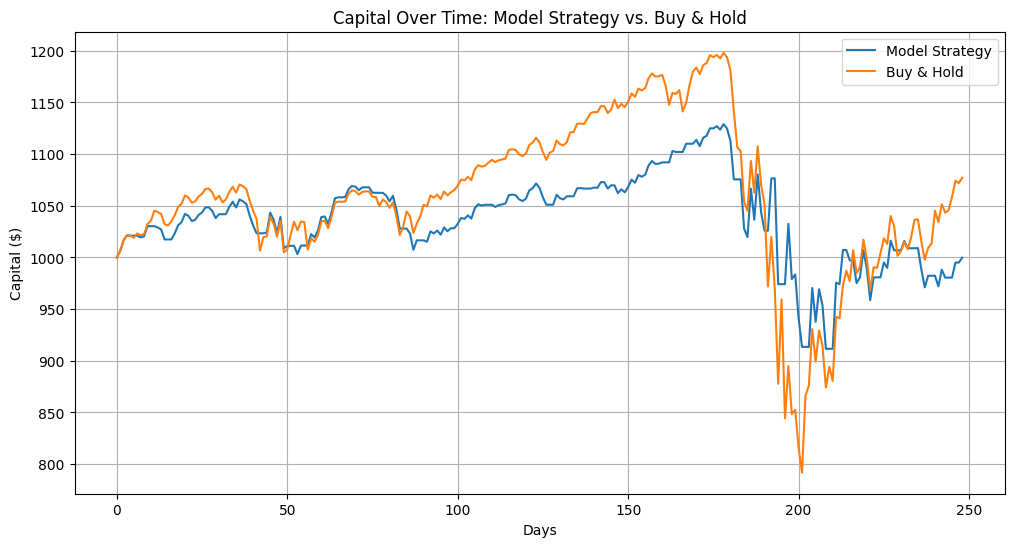

In [6]:
import matplotlib.pyplot as plt

model_capital = [x['^GSPC'] if isinstance(x, pd.Series) else x for x in model_capital]
buy_hold_capital = [x['^GSPC'] if isinstance(x, pd.Series) else x for x in buy_hold_capital]
plt.figure(figsize=(12,6))
plt.plot(model_capital, label='Model Strategy')
plt.plot(buy_hold_capital, label='Buy & Hold')
plt.xlabel('Days')
plt.ylabel('Capital ($)')
plt.title('Capital Over Time: Model Strategy vs. Buy & Hold')
plt.legend()
plt.grid()
plt.show()

Here we calculated the Sharpe Ratio for the model-based trading strategy and a traditional buy-and-hold approach. We generally had a similar value for sharpe ratio which indicated they provide similar risk adjusted returns.

In [ ]:
model_returns = np.diff(model_capital) / model_capital[:-1]
buy_hold_returns = np.diff(buy_hold_capital) / buy_hold_capital[:-1]

model_volatility = np.std(model_returns)
buy_hold_volatility = np.std(buy_hold_returns)

model_sortino = np.mean(model_returns) / np.std(model_returns[model_returns < 0])
buy_hold_sortino = np.mean(buy_hold_returns) / np.std(buy_hold_returns[buy_hold_returns < 0])

model_sharpe = np.mean(model_returns) / model_volatility
buy_hold_sharpe = np.mean(buy_hold_returns) / buy_hold_volatility

model_cum_return = (final_model_cap - initial_capital) / initial_capital
bh_cum_return = (final_bh_cap - initial_capital) / initial_capital

print(f"\nModel Cumulative Return: {model_cum_return:.2%}")
print(f"Buy & Hold Cumulative Return: {bh_cum_return:.2%}")

print(f"\nModel Sharpe Ratio: {model_sharpe:.5f}")
print(f"Buy & Hold Sharpe Ratio: {buy_hold_sharpe:.5f}")

print(f"\nModel Sortino  Ratio: {model_sortino:.5f}")
print(f"Buy & Hold Sortino  Ratio: {buy_hold_sortino:.5f}")


print(f"\nModel Volatility: {model_volatility:.5f}")
print(f"Buy & Hold Volatility: {buy_hold_volatility:.5f}")



Model Cumulative Return: -0.02%
Buy & Hold Cumulative Return: 7.72%

Model Sharpe Ratio: 0.00752
Buy & Hold Sharpe Ratio: 0.02494

Model Sortino  Ratio: 0.00764
Buy & Hold Sortino  Ratio: 0.02722

Model Volatility: 0.01506
Buy & Hold Volatility: 0.02065


Evaluation metrics where we calculated the maximum drawdowns of each strategy.

In [12]:
def max_drawdown(capital):
    peak = np.maximum.accumulate(capital)
    drawdown = (capital - peak) / peak
    return np.min(drawdown)

model_max_drawdown = max_drawdown(model_capital)
buy_hold_max_drawdown = max_drawdown(buy_hold_capital)

print(f"\nMaximum Drawdowns (Model): {model_max_drawdown:.5f}")
print(f"Maximum Drawdowns Buy & Hold: {buy_hold_max_drawdown:.5f}")


Maximum Drawdowns (Model): -0.19260
Maximum Drawdowns Buy & Hold: -0.33925
